<a href="https://colab.research.google.com/github/svanbergaddi/ece278a/blob/main/278final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal line technology

Can we use methods in image processing to minimize goal line decision errors in soccer?

- Needs to determine whether a soccer ball goes over the goal line or not.
- Would help with both goal line decisions and side or endline decisions to make it easier for soccer referees.

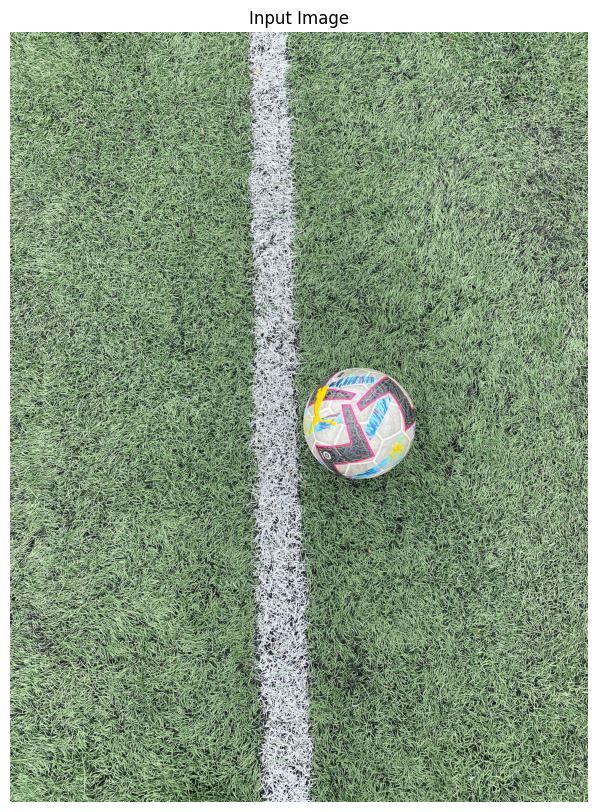

In [ ]:
import cv2
import numpy as np
from skimage import filters
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
#imagepath = "England2006.jpg"
image = cv2.imread(imagepath)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.title('Input Image')
plt.axis('off')
plt.show()

#Code

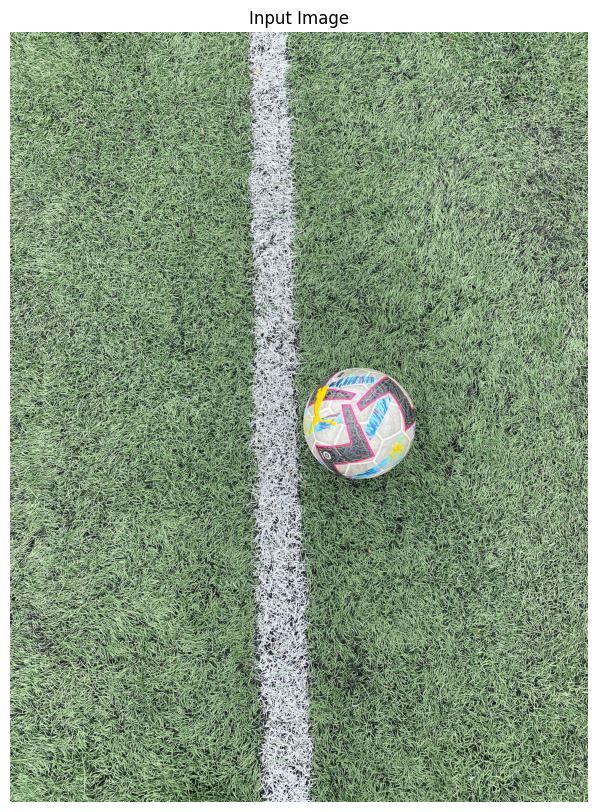

In [ ]:
#imagepath = "In.jpg"
#imagepath = "Online.jpg"
imagepath = "closein.jpg"
#imagepath = "Closeout.jpg"
#imagepath = "Short.jpg"


image = cv2.imread(imagepath)

if image is None:
    print(f"Error: Unable to load image at {imagepath}")
else:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.title('Input Image')
    plt.axis('off')
    plt.show()

Text(0.5, 1.0, 'Sobel Edges')

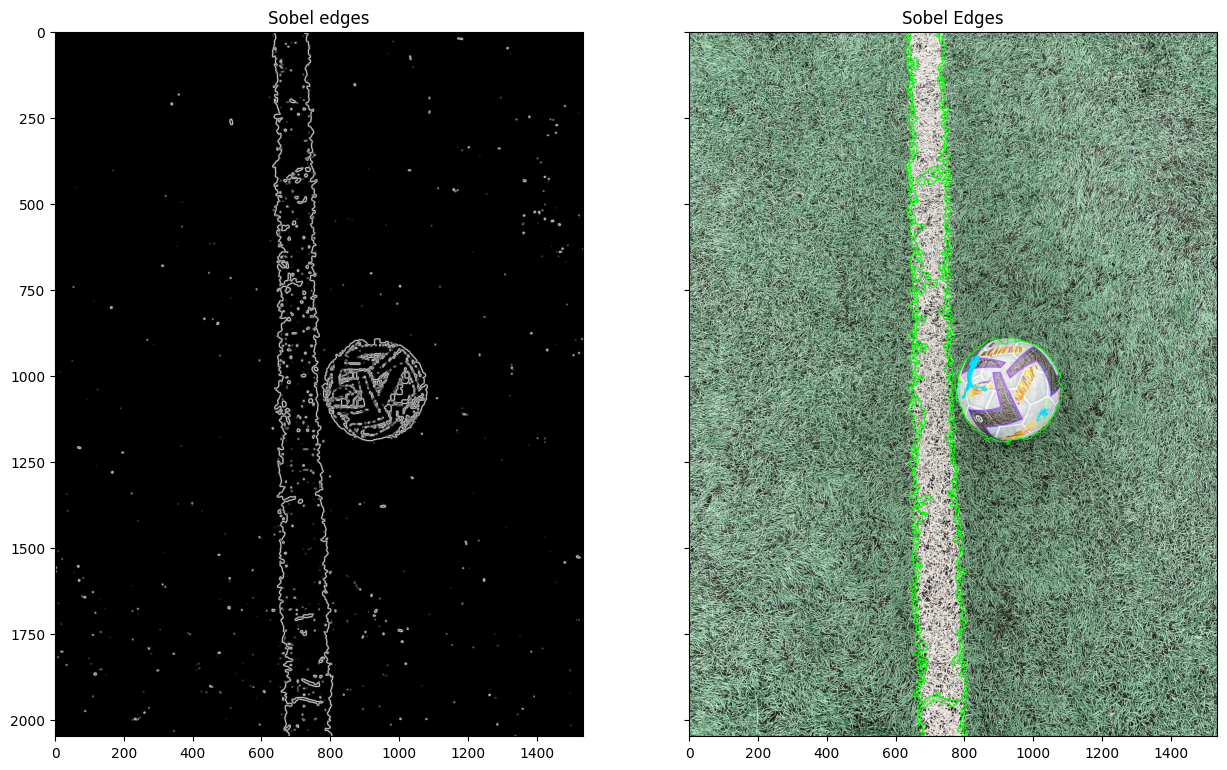

In [ ]:
# Convert the image to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Color thresholding to segment the non-green areas (e.g., ball and line)
Green_lower = np.array([36, 0, 0])
Green_upper = np.array([86, 255, 255])
mask = cv2.inRange(hsv_image, Green_lower, Green_upper)
mask = cv2.bitwise_not(mask)  # Invert mask to get non-green areas

# Apply Gaussian blur
blurred = gaussian_filter(mask,sigma=1)
#Sobel edge detection
sobel_edges = filters.sobel(blurred)
#since cv2Contours requires 8-bit single channel image as input, ensures everything is between 0-255
sobel_edges_uint8 = (sobel_edges * 255).astype(np.uint8)

# Find contours
contours, _ = cv2.findContours(sobel_edges_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #RETR_EXTERNAL=just the outside of the object, Chainapprox=reduces number of points defining a contour
# Filter contours by size to keep only the two largest
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:3]
# Draw contours on the original image for visualization
output_image = image.copy()
cv2.drawContours(output_image, contours, -1, (0, 255, 0), 2)

fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(15, 10))
axes[0].imshow(sobel_edges, cmap='gray')
axes[0].set_title('Sobel edges')
axes[1].imshow(output_image, cmap='gray')
axes[1].set_title('Sobel Edges')

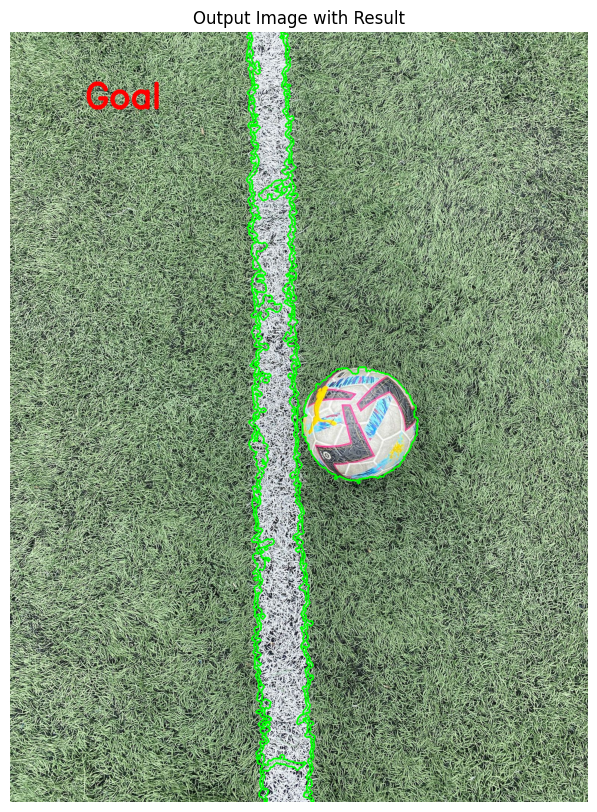

In [ ]:
# Function to analyze contour properties
def analyze_contour_properties(contour):
    area = cv2.contourArea(contour)
    x, y, w, h = cv2.boundingRect(contour)
    #Calculate the aspect ratio of the bounding rectangle
    ratio = float(w) / h
    #Calculate ratio of contour area to bounding rect area
    extent = float(area) / (w * h)
    #smallest convex polygon that completely encloses the contour
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area
    return ratio, extent, solidity

# Check the quality of the ball contour
def is_contour_ball(contour):
    ratio, extent, solidity = analyze_contour_properties(contour)
    #ratio, checks if its roughly circular,
    #extent checks if it occupies at least half its bounding rect
    #contour should be very close to the convex hull, no significant concavities
    return 0.8 < ratio < 1.2 and extent > 0.5 and solidity > 0.9

# Check if the contours are touching or close to each other
def contours_touch_or_close(contour1, contour2):
    dist_thresh = 10  # Distance threshold to consider contours touching or close
    for point1 in contour1:
        for point2 in contour2:
            if np.linalg.norm(point1 - point2) < dist_thresh:
                return True
    return False

# Get the centroid of a contour
def get_contour_centroid(contour):
    #gives information about contours shape and orientation
    M = cv2.moments(contour)
    #checks if area of contour is zero
    if M["m00"] == 0:
        return None
    #calculate coordinates of centroid
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return cX, cY

if len(contours) >= 2:
    ball_contour = contours[0] if is_contour_ball(contours[0]) else contours[1]
    other_contour = contours[1] if ball_contour is contours[0] else contours[0]

    ball_centroid = get_contour_centroid(ball_contour)
    line_centroid = get_contour_centroid(other_contour)

    if is_contour_ball(ball_contour):
        if contours_touch_or_close(ball_contour, other_contour):
            result_text = "Not a Goal"
        else:
            #checks if the ball is left of the line
            if ball_centroid and line_centroid and ball_centroid[0] < line_centroid[0]:
                result_text = "Not a Goal"
            else:
                result_text = "Goal"
    else:
        result_text = "Not a Goal"
else:
    result_text = "Not enough objects detected"

output_image = image.copy()
cv2.drawContours(output_image, contours, -1, (0, 255, 0), 3)
cv2.putText(output_image, result_text, (200, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 10, cv2.LINE_AA)

# Display the output image with the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title('Output Image with Result')
plt.axis('off')
plt.show()
